In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
pip list

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu,True)
    print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist',split='train')

ds.as_numpy_iterator().next()['image']

In [ ]:
import numpy as np

data_iterator =ds.as_numpy_iterator()

data_iterator.next()

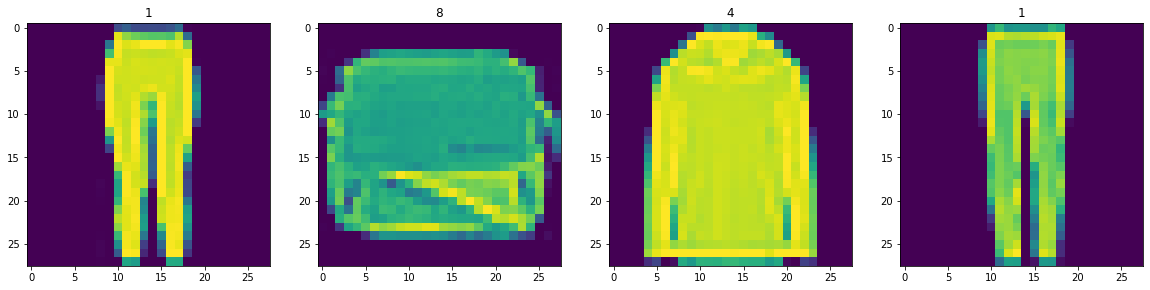

In [5]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))

for idx in range(4):
    sample = data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [6]:
def scale_images(data):
    image = data['image']
    return image/255

In [7]:
# map
# cache
# shuffle
# batch
# prefetch

ds = tfds.load('fashion_mnist',split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)


In [ ]:
ds.as_numpy_iterator().next()

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

In [10]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128,input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128 )))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))    
    
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1,4,padding='same',activation='sigmoid'))

    
    return model


In [11]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [25]:
import numpy as np

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
img

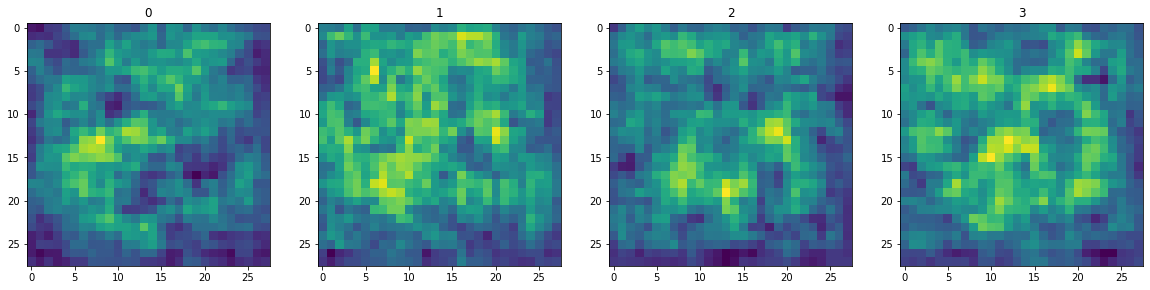

In [27]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))

for idx,img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [23]:
def build_discriminator():

    model = Sequential()
    
    model.add(Conv2D(32,5,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    
    

    return model


In [24]:
discriminator = build_discriminator()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)      

In [29]:
discriminator.predict(img)

1/1 [==============================] - 0s 114ms/step


array([[0.50808567],
       [0.50821537],
       [0.5080036 ],
       [0.5081543 ]], dtype=float32)

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [31]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss= BinaryCrossentropy()


In [32]:
from tensorflow.keras.models import Model


In [33]:
class FashionGAN(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss=g_loss
        self.d_loss = d_loss
    
    def train_step(self,batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)),training = False)
    
    
        #train discriminator
        
        with tf.GradientTape() as d_tape:

            yhat_real = self.discriminator(real_images,training=True)
            yhat_fake = self.discriminator(fake_images,training=True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)

            #labels
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake+=tf.concat([noise_real,noise_fake],axis=0)

            total_d_loss = self.d_loss(y_realfake,yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients (zip(dgrad,self.discriminator.trainable_variables))
        
        
    
        #train generator

        with tf.GradientTape() as g_tape:

            gen_images = self.generator(tf.random.normal((128,128,1)),training=True)

            predicted_labels = self.discriminator(gen_images,training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

        ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

        return {"d_loss":total_d_loss,"g_loss":total_g_loss}
    
     
        

In [34]:
fashgan = FashionGAN(generator,discriminator)


In [35]:
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

In [37]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [38]:
class ModelMonitor(Callback):
    def __init__(self,num_img=3,latent_dim=128):
        self.num_img=num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self,epoch,logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images*=255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('generated_images_while_training',f'generated_img_{epoch}_{i}.png'))

In [40]:
hist = fashgan.fit(ds,epochs=1000,callbacks=[ModelMonitor()])

Epoch 1/1000
469/469 [==============================] - 50s 105ms/step - d_loss: 0.4845 - g_loss: 1.5217
Epoch 2/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6973 - g_loss: 0.6901
Epoch 3/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6643 - g_loss: 0.6780
Epoch 4/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6739 - g_loss: 0.4390
Epoch 5/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6940 - g_loss: 0.5947
Epoch 6/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6976 - g_loss: 0.6202
Epoch 7/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6951 - g_loss: 0.6444
Epoch 8/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6937 - g_loss: 0.6477
Epoch 9/1000
469/469 [==============================] - 50s 106ms/step - d_loss: 0.6934 - g_loss: 0.6558
Epoch 10/1000
469/469 [==============================] 

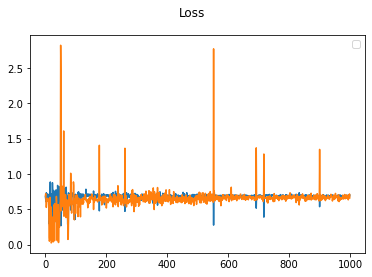

In [41]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'])
plt.plot(hist.history['g_loss'])
plt.legend()
plt.show()

In [ ]:
# generator.load_weights('path to weight')

1/1 [==============================] - 0s 77ms/step


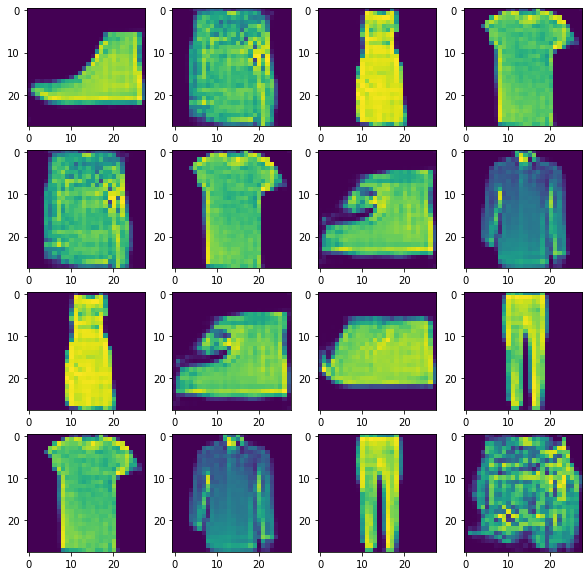

In [42]:
imgs = generator.predict(tf.random.normal((16,128,1)))

fig,ax = plt.subplots(ncols=4,nrows=4,figsize=(10,10))

for row in range(4):
    for col in range(4):
        ax[row][col].imshow(imgs[(row+1)*(col+1)-1])

In [ ]:
# generator.save('generator.h5')
# discriminator.save('discriminator.h5') 